In [1]:
import sys
import yaml
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['font.size'] = 12
matplotlib.rcParams['font.family'] = 'Arial'

from shapely import box

%matplotlib inline
%config InlineBackend.figure_format='retina'


In [2]:
from zeroheliumkit import Rectangle, Structure, Square
from zeroheliumkit.src.settings import *
from zeroheliumkit.helpers.constants import *
from zeroheliumkit.fem import *

def scaling_size(bulk_helium_distance: float=1e-1):
    lengthscale = (rho * g * bulk_helium_distance)/alpha * 1e-6      # in um
    return lengthscale

save_dir = "dump/"

plot_config = {"wafer": LIGHTGRAY,
               "gnd": BLUE,
               "top": ORANGE,
               "bottom": YELLOW2,
               "skeletone": DARKGRAY,
               "anchors": RED}

<Axes: >

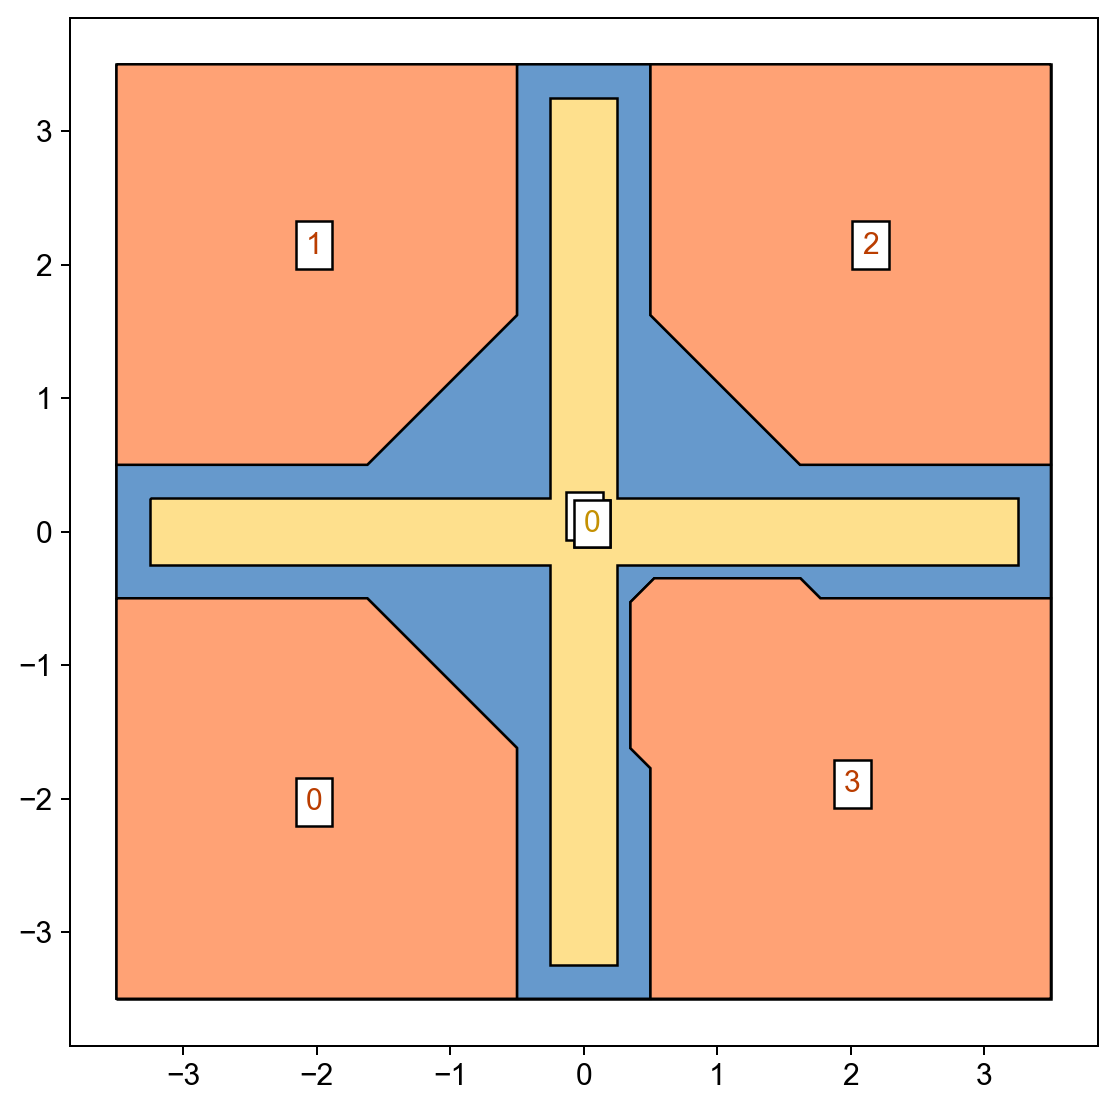

In [3]:
channel = Structure()

channel.add_layer("gnd")
channel.add_polygon("gnd", Rectangle(7, 1))
channel.add_polygon("gnd", Rectangle(1, 7))
channel.add_polygon("gnd", Rectangle(3, 3, (0,0), 45))
channel.cut_polygon("gnd", Rectangle(3, 1.8, (1.5,-1.5), -45))

channel.add_layer("bottom")
channel.add_polygon("bottom", Rectangle(6.5, 0.5))
channel.add_polygon("bottom", Rectangle(0.5, 6.5))
channel.add_polygon("gnd", channel.bottom.buffer(0.1))
channel.add_layer("wafer", Square(7))
channel.add_layer("top", Square(7))
channel.cut_polygon("top", channel.gnd)

channel.quickplot(plot_config, show_idx=True)

<Axes: >

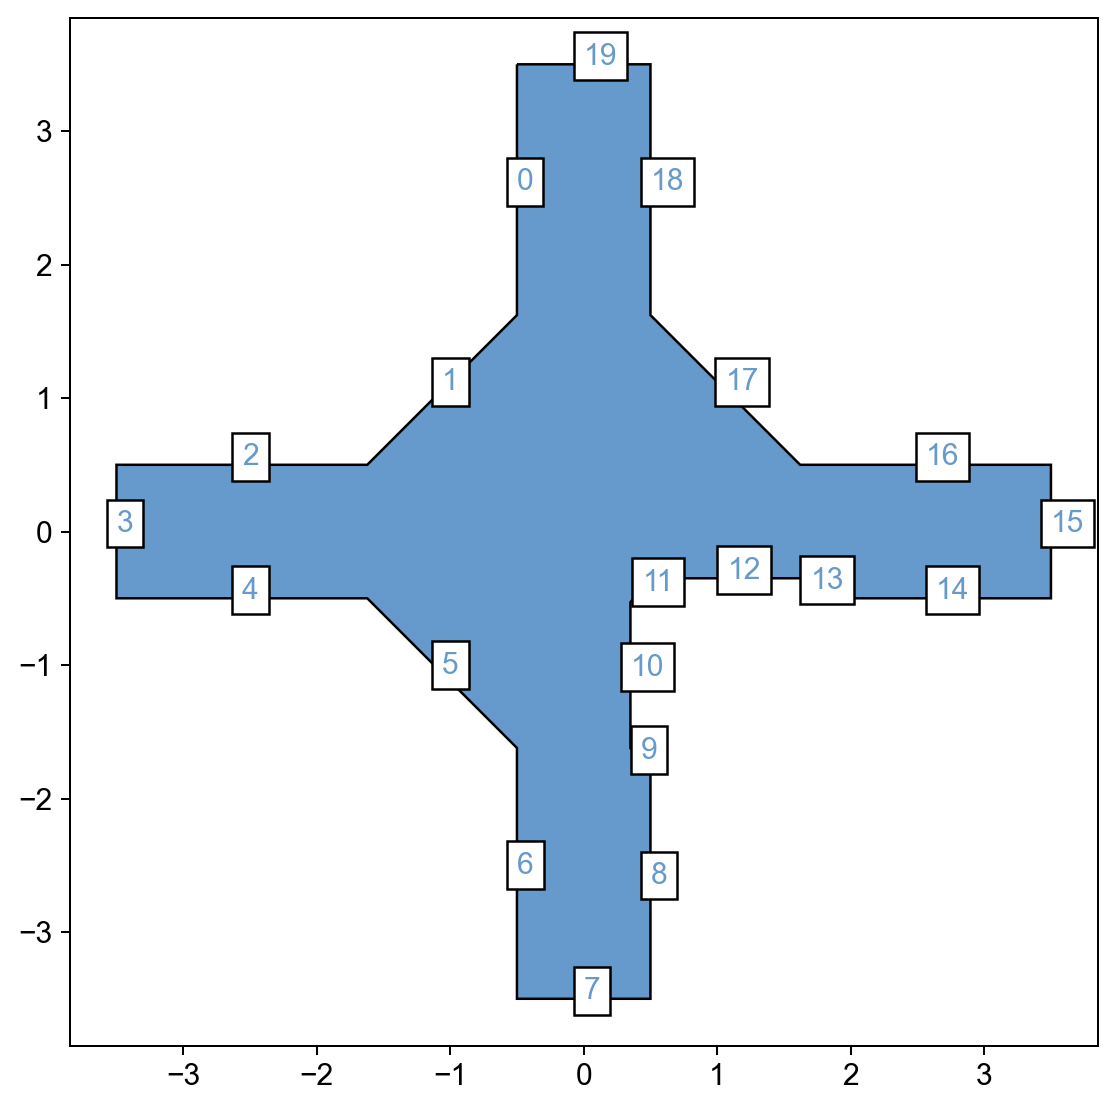

In [4]:
s = Structure()
s.add_layer("gnd", channel.gnd)
s.quickplot(plot_config, show_line_idx=True)

In [7]:
gmshmkr = GMSHmaker2D(layout = s,
                      electode_config = {"type": "polygon",
                                         "bound": {"layer": ("gnd", (0,)), "exclude": [3, 15], "value": 0}},
                      mesh_config = [{"Thickness": 5, "VIn": 0.9, "VOut": 0.9, "box": [-20, -20, 20, 20]}],
                      filename = "heliumsurface",
                      savedir = "")
gmshmkr.disable_consoleOutput()
gmshmkr.create_mesh()
#gmshmkr.open_gmsh()
gmshmkr.finalize()

Gmsh generation |███| 1/1 [100%] in 0.1s (9.79/s)                               


In [8]:
hsfreefem = HeliumSurfaceFreeFEM(fem_config=gmshmkr.export_physical())
res = hsfreefem.run_pyfreefem()

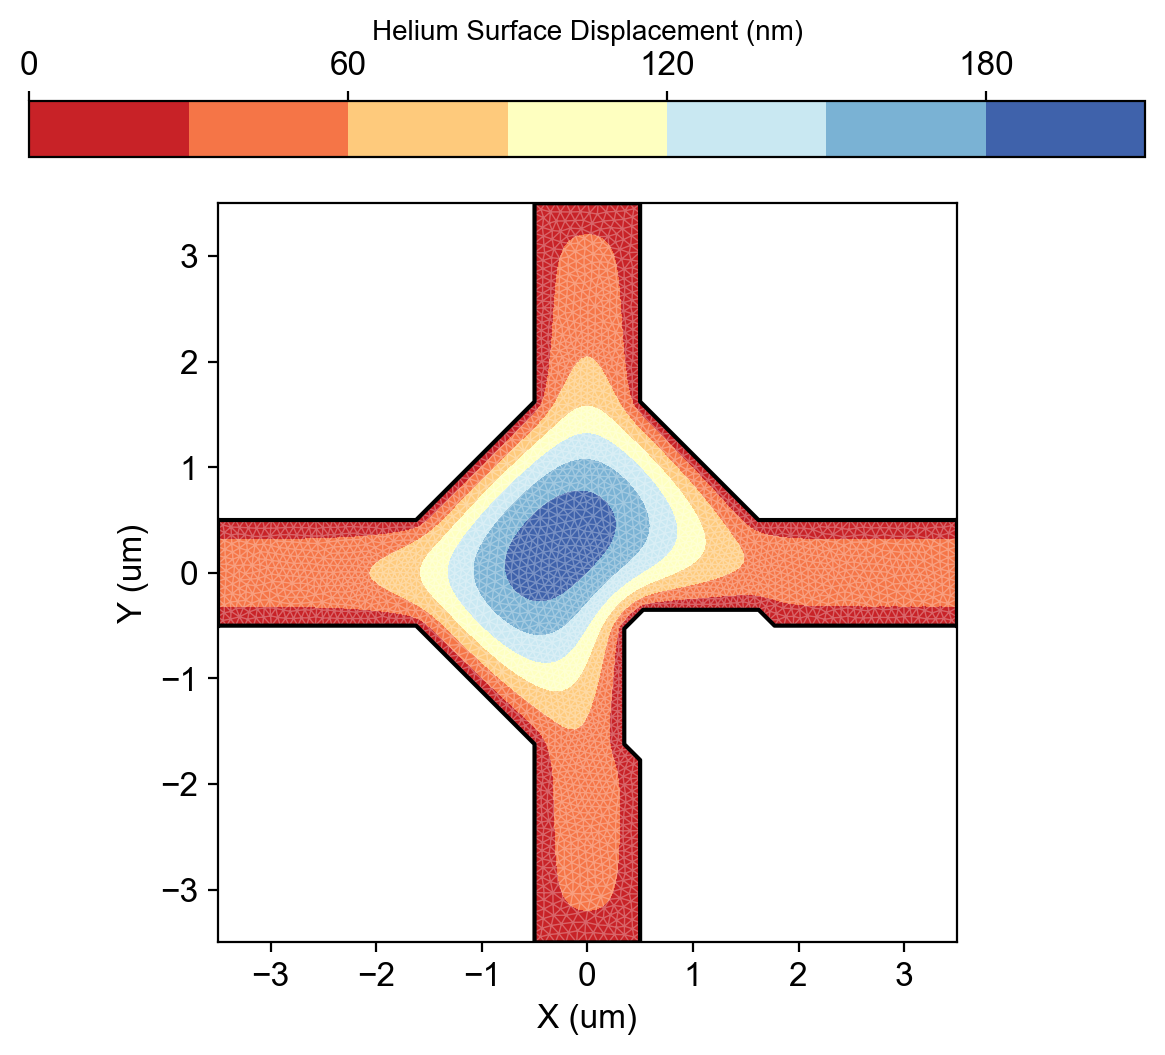

In [9]:
hsfreefem.plot_results(res, bulk_helium_distance=0.1)

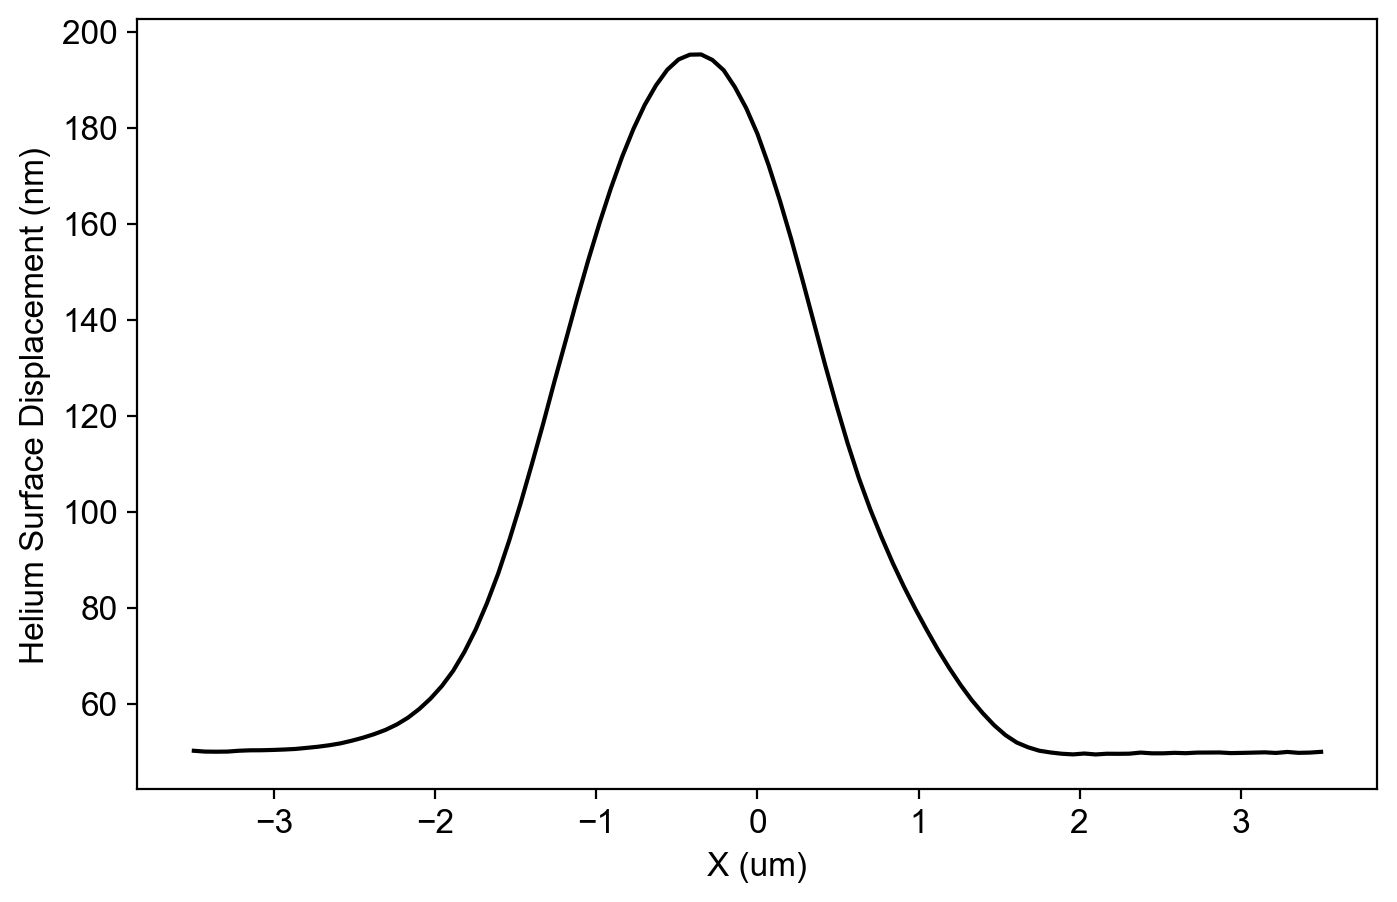

In [10]:
hsfreefem.plot_1D(res, bulk_helium_distance=0.1, xlist=np.linspace(-3.5, 3.5, 101), cut_axis="x", cut_value=-0.)

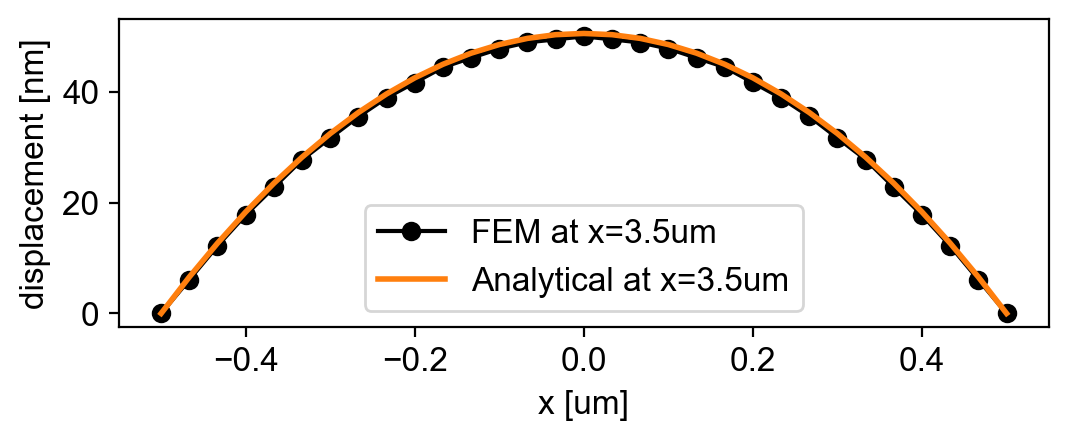

In [11]:
d = 0.1
xlim = 0.5

plt.figure(figsize=(6,2))
ax = plt.subplot(111)

xx = np.linspace(-xlim, xlim, 31)

hsfreefem.plot_1D(res, bulk_helium_distance=d, ax=ax, xlist=xx, cut_axis="y", cut_value=3.5, marker="o", label="FEM at x=3.5um")

Rc = 1/scaling_size(d)
ax.plot(xx, (np.sqrt(Rc**2 - xx**2) - np.sqrt(Rc**2 - xlim**2))*1e3, '-', c="C1", lw=2, label="Analytical at x=3.5um")
ax.legend()

ax.set_ylabel("displacement [nm]")
ax.set_xlabel("x [um]")
plt.show()

## **Electrostatic Calculations / Extracting results along curved surface**

In [14]:
d_wafer     = 20
d_He        = 1
d_metal1    = 0.05
d_metal2    = 0.05
d_diel      = d_He - d_metal2
d_vac       = 20

msh_filename = 'dot'

extrude_params = {"wafer": d_wafer,
                  "metal_bottom": d_metal1,
                  "metal_top": d_metal2,
                  "helium": d_He,
                  "dielectric": d_diel,
                  "vacuum": d_vac}

In [15]:
""" 
extrude_config: 
key - gmsh layer name
item - gmshLayer_info dict: 
       (geometry layer, thickness, z0, Physical Vol Name, CUT gmsh layer=None, forConstruction=False)
"""
extrude_config = {
    'wafer':        gmshLayer_info('wafer', -d_wafer, d_wafer, 'DIELECTRIC'),
    'bottom':       gmshLayer_info('bottom', 0, d_metal1, 'METAL'),
    'dielectric':   gmshLayer_info('top', 0, d_diel, 'DIELECTRIC'),
    'top':          gmshLayer_info('top', d_diel, d_metal2, 'METAL'),
    'helium':       gmshLayer_info('wafer', 0, d_He, 'HELIUM', ('bottom','dielectric','top')),
    'vacuum':       gmshLayer_info('wafer', d_He, d_vac, 'VACUUM', ('helium','top'))
}

""" 
electrodes_config: 
key - physicalSurface name
item - physSurface_info dict:
       (geometry layer, electrode idx in geometry layer, gmsh layer)
"""
electrodes_config = {
    'bottom':   physSurface_info('bottom', [0], 'bottom'),
    'top':      physSurface_info('top', [0,1,2,3], 'top'), 
}

scale = 4 # scaling factor for meshing. default 1.8

mesh_cfg = [{"Thickness": 4, "VIn": scale * 0.3, "VOut": 2, "box": [-10, 10, -10, 10, -5, 5]},
            {"Thickness": 2, "VIn": scale * 0.05, "VOut": 2, "box": [-10, 10, -10, 10, -1, 3]}
            ]

In [16]:
meshMKR =  GMSHmaker(layout=channel, 
                     extrude_config=extrude_config, 
                     electrodes_config=electrodes_config, 
                     mesh_params=mesh_cfg)
meshMKR.disable_consoleOutput()
#meshMKR.create_geo(save_dir + msh_filename)
meshMKR.export_physical(save_dir)
meshMKR.create_mesh(save_dir + msh_filename, dim=3)
meshMKR.open_gmsh()
meshMKR.finalize()

on 0: mesh is constructed                                                       
on 0: mesh saved                                                                
Gmsh generation |███| 1/1 [100%] in 2.0s (0.51/s)                               


In [18]:
curvature_config = hsfreefem.get_code_config(bulk_helium_distances=[0, 0.01, 0.1], surface_helium_level=d_He)

In [19]:
He_level = d_He

var_eps = {
        'DIELECTRIC': 11.0,
        'METAL': 1.0,
        'HELIUM': 1.057,
        'VACUUM': 1.0,
}

ff_config ={
    'meshfile': msh_filename,
    'dielectric_constants': var_eps,
    'ff_polynomial': 2,
    'extract_opt': [extract_results('phi', 'xyZ', (-3.5,3.5,151), (-3.5,3.5,151), None, additional_name="curvedslices"),],
    'include_helium_curvature': curvature_config
}


with open('dump//gmsh.yaml', 'r') as file:
    gmsh_physical_config = yaml.safe_load(file)


ff_config_path = 'dump/fem.yaml'
with open(ff_config_path, 'w') as file:
    documents = yaml.safe_dump(ff_config | gmsh_physical_config | dict(GMSH=dict(extrude_params=extrude_params)), file)

In [20]:
with open(ff_config_path, 'r') as file:
    config = yaml.safe_load(file)

pyff = FreeFEM(config=config,
               dirname=save_dir,
               run_from_notebook=False)

In [21]:
from zeroheliumkit.fem import FieldAnalyzer

In [23]:
results = FieldAnalyzer((save_dir+"curvedslices_phi_xyZ.txt", 'dot', '2Dslices'),)
print(results.dot.keys())
print(results.dot["bottom"].keys())

dict_keys(['bottom', 'top', 'xlist', 'ylist'])
dict_keys(['0', '0.01', '0.1'])


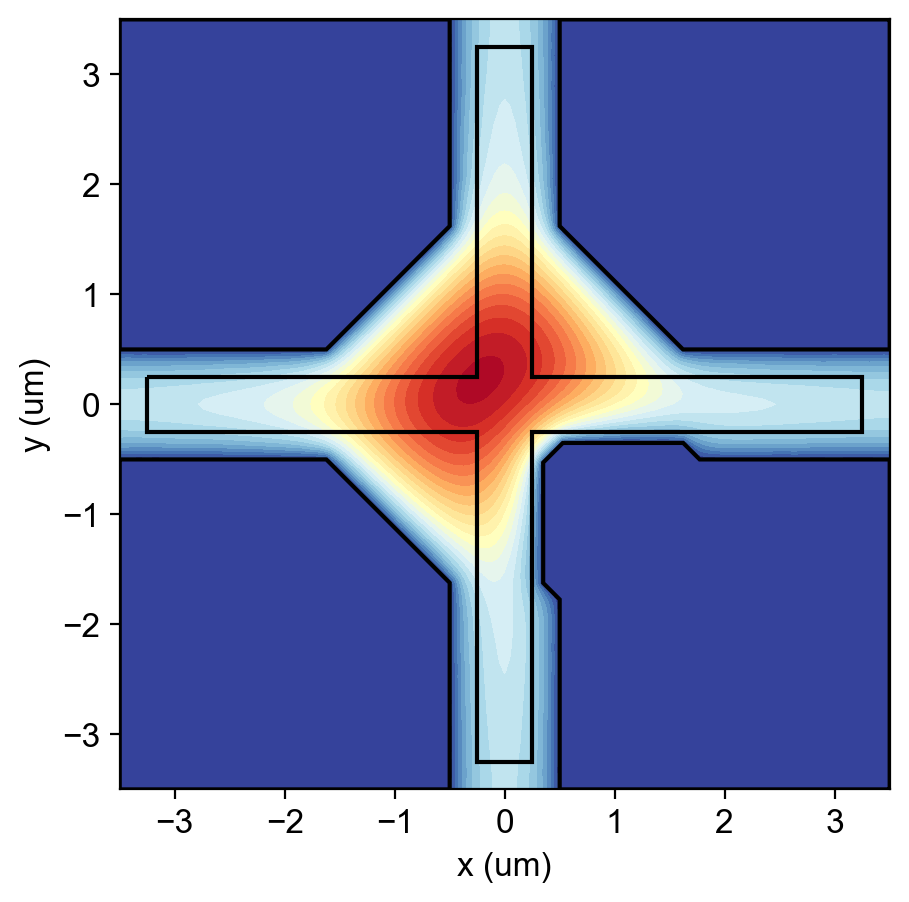

In [27]:
voltages = {
    'bottom':   0.55,
    'top':      0,
}

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)

results.plot_potential_2D(results.dot, voltages, ax=ax, zlevel_key='0.01', cmap='RdYlBu_r', levels=31)
channel.plot(ax=ax, layer=["top", "bottom"], color=[BLACK, BLACK], alpha=0)

ax.set_aspect("equal")
ax.set_ylabel("y (um)")
ax.set_xlabel("x (um)")

#plt.savefig(plot_dir+'trap.png', dpi=300)
plt.show()

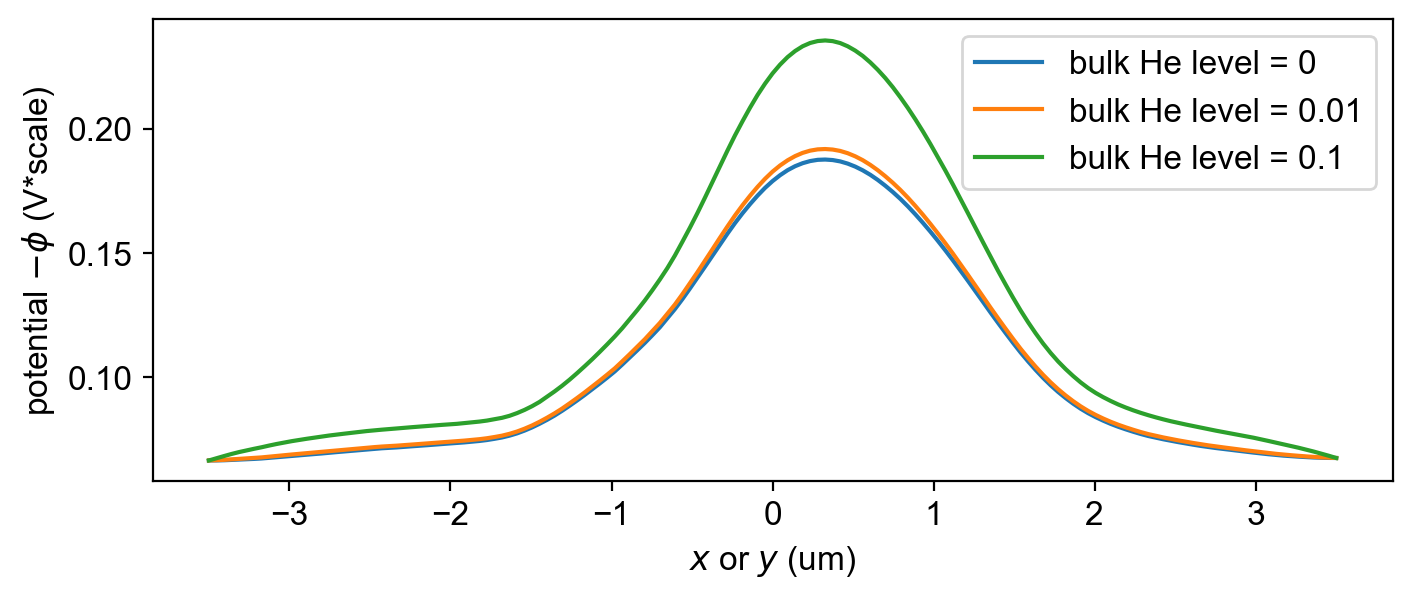

In [31]:
fig = plt.figure(figsize=(8, 3))
ax = fig.add_subplot(111)

results.plot_potential_1D(results.dot, voltages, xy_cut="y", loc=0, ax=ax, zlevel_key='0', scale=1, label="bulk He level = 0")
results.plot_potential_1D(results.dot, voltages, xy_cut="y", loc=0, ax=ax, zlevel_key='0.01', scale=1, label="bulk He level = 0.01")
results.plot_potential_1D(results.dot, voltages, xy_cut="y", loc=0, ax=ax, zlevel_key='0.1', scale=1, label="bulk He level = 0.1")

ax.legend()

#ax.set_ylim(-10, 210)
#ax.set_xlim(-1., 1.)

plt.show()